## Purpose: to see the the evolution of correlation between the predictions through epochs

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score
import os
import yaml

#### Load the embeddings for a given model

In [142]:
def get_models_path(rootdir):
    """
    Select all the model directories from a multirun session.

    Parameters
    ----------
    rootdir: str
        path which leads to the directories of the models
    
    Return
    ------
    list_model: list of str
        list of the directories of the different models
    """
    for d in os.listdir(rootdir):
        if d.endswith('.csv'):
    #        with open(f"{rootdir}{el}", 'r') as csvfile:
    #            for line in csvfile:
    #                 print(line)
            list_model = pd.read_csv(f'{rootdir}{d}')
            list_model = np.array([i[0] for i in list_model.to_numpy()])
        else :
            list_model = [d for d in os.listdir(rootdir) if '.' not in d]
            return list_model
    list_model = list_model[[model in os.listdir(rootdir) for model in list_model]]
    return list_model

def check_embeddings(path):
    """
    Check if the embeddings were created for ACCP, HCP and UKB.

    Parameters
    ----------
    path: str
        path which leads to the directories of the embeddings for one given model
    
    Return
    ------
    check_value: bol
        True if ACCP, UKB and HCP have at least one representant
    """
    check_value_ACCP = False
    check_value_HCP = False
    check_value_UKB = False

    list_ebdd_ACCP = ['acc_', 'accp']
    list_ebdd_HCP = ['hcp_']
    list_ebdd_UKB = ['ukb_', 'ukbi']

    for dir in os.listdir(path):
        if dir[0:4].lower() in list_ebdd_ACCP:
            check_value_ACCP = True
        if dir[0:4].lower() in list_ebdd_HCP:
            check_value_HCP = True
        if dir[0:4].lower() in list_ebdd_UKB:
            check_value_UKB = True

    if not check_value_ACCP:
        print('ACCP embeddings are missing')
    if not check_value_HCP:
        print('HCP embeddings are missing')
    if not check_value_UKB:
        print('UKB embeddings are missing')
        
    return check_value_ACCP & check_value_HCP & check_value_UKB


# où trouver le nombre d'epoques ? Est-ce dans le fichier .yaml ?   
# cette fonction est provisoire
def get_epochs(path):
    '''
    Parameters
    ----------
    path: str
        path which leads to the directories of the embeddings for one given model
    
    Return
    ------
    epochs: set of int
        set of the epoch for which we can access to the model weights
    '''        

    epochs = []
    for dir in os.listdir(path):
        if dir.endswith('embeddings'):
            num = ''
            for c in dir[-13:-11]:
                if c.isdigit():
                    num = num + c
            if num != '':
                epochs.append(int(num))
    
    return set(epochs)

def loader(path, epoch):
    '''
    Parameters
    ----------
    path: str
        path which leads to the directories of the embeddings for one given model
    
    Return
    ------
    epochs: set of int
        set of the epoch for which we can access to the model weights
    '''

    if os.path.isfile(f"{path}ACCP_random_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_ACCP = pd.read_csv(f"{path}ACCP_random_epoch{epoch}_embeddings/full_embeddings.csv")
    elif os.path.isfile(f"{path}acc_random_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_ACCP = pd.read_csv(f"{path}acc_random_epoch{epoch}_embeddings/full_embeddings.csv")
    elif os.path.isfile(f"{path}accp_random_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_ACCP = pd.read_csv(f"{path}accp_random_epoch{epoch}_embeddings/full_embeddings.csv")
    elif os.path.isfile(f"{path}ACC_random_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_ACCP = pd.read_csv(f"{path}ACC_random_epoch{epoch}_embeddings/full_embeddings.csv")
    elif os.path.isfile(f"{path}ACCP_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_ACCP = pd.read_csv(f"{path}ACCP_epoch{epoch}_embeddings/full_embeddings.csv")
    elif os.path.isfile(f"{path}acc_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_ACCP = pd.read_csv(f"{path}acc_epoch{epoch}_embeddings/full_embeddings.csv")
    elif os.path.isfile(f"{path}accp_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_ACCP = pd.read_csv(f"{path}accp_epoch{epoch}_embeddings/full_embeddings.csv")
    elif os.path.isfile(f"{path}ACC_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_ACCP = pd.read_csv(f"{path}ACC_epoch{epoch}_embeddings/full_embeddings.csv")
    else :
        return print(f'ACCP embeddings for epoch {epoch} not found at {path}')

    if os.path.isfile(f"{path}HCP_random_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_HCP = pd.read_csv(f"{path}HCP_random_epoch{epoch}_embeddings/full_embeddings.csv", index_col=0)
    elif os.path.isfile(f"{path}hcp_random_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_HCP = pd.read_csv(f"{path}hcp_random_epoch{epoch}_embeddings/full_embeddings.csv", index_col=0)
    elif os.path.isfile(f"{path}HCP_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_HCP = pd.read_csv(f"{path}HCP_epoch{epoch}_embeddings/full_embeddings.csv", index_col=0)
    elif os.path.isfile(f"{path}hcp_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_HCP = pd.read_csv(f"{path}hcp_epoch{epoch}_embeddings/full_embeddings.csv", index_col=0)
    else :
        return print(f'HCP embeddings for epoch {epoch} not found at {path}')

    if os.path.isfile(f"{path}UKB_random_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_UKB = pd.read_csv(f"{path}UKB_random_epoch{epoch}_embeddings/full_embeddings.csv", index_col=0)
    elif os.path.isfile(f"{path}ukb_random_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_UKB = pd.read_csv(f"{path}ukb_random_epoch{epoch}_embeddings/full_embeddings.csv", index_col=0)
    elif os.path.isfile(f"{path}UKB_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_UKB = pd.read_csv(f"{path}UKB_epoch{epoch}_embeddings/full_embeddings.csv", index_col=0)
    elif os.path.isfile(f"{path}ukb_epoch{epoch}_embeddings/full_embeddings.csv"):
        embeddings_UKB = pd.read_csv(f"{path}ukb_epoch{epoch}_embeddings/full_embeddings.csv", index_col=0)
    else :
        return print(f'UKB embeddings for epoch {epoch} not found at {path}')

    return embeddings_ACCP, embeddings_HCP, embeddings_UKB

Labelization of ACCP

In [129]:
def encoder(df, columns):
    for col in columns:
        code = {'present':1,
                'absent':0}
        df[col] = df[col].map(code)
    return df

labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
labels_ACCP = labels_ACCP[['long_name','Left_PCS', 'Right_PCS']]

encoder(labels_ACCP, ['Left_PCS', 'Right_PCS']) 
labels_ACCP['Asymmetry'] = abs(labels_ACCP.Left_PCS - labels_ACCP.Right_PCS)
labels_ACCP['Two_PCS'] = labels_ACCP.Left_PCS & labels_ACCP.Right_PCS
labels_ACCP['Zero_PCS'] = (1-labels_ACCP.Left_PCS) & (1-labels_ACCP.Right_PCS)
labels_ACCP['Left_without_Right_PCS'] = (labels_ACCP.Left_PCS) & (1-labels_ACCP.Right_PCS)
labels_ACCP['Right_without_Left_PCS'] = (1-labels_ACCP.Left_PCS) & (labels_ACCP.Right_PCS)

#### Scale the embeddings (fit on UKB)

In [130]:
list_to_drop = ['Asymmetry','Left_PCS','Right_PCS','Two_PCS','Zero_PCS','Right_without_Left_PCS','Left_without_Right_PCS']

def chose_target(target, embeddings_ACCP, labels_ACCP):
    
    ebdd_lbl_ACCP = embeddings_ACCP.set_index('ID').join(labels_ACCP.set_index('long_name'))
    X = ebdd_lbl_ACCP.drop(list_to_drop, axis=1)
    y = ebdd_lbl_ACCP[target]
    return ebdd_lbl_ACCP, X, y

def scale_based_on_UKB(embeddings_ACCP, embeddings_HCP, embeddings_UKB):

    scaler = StandardScaler()
    scaler.fit(embeddings_UKB.to_numpy())
    scl_bdd_accp = scaler.transform(embeddings_ACCP.to_numpy())
    scl_bdd_hcp = scaler.transform(embeddings_HCP.to_numpy())
    scl_bdd_ukb = scaler.transform(embeddings_UKB.to_numpy())

    return scl_bdd_accp, scl_bdd_hcp, scl_bdd_ukb, scaler

#### Classify the embeddings (fit on ACCP)

In [156]:
def classifier():
    
    model = SVC(kernel='linear', probability=True,
                random_state=42,
                C=0.01, class_weight='balanced', decision_function_shape='ovr')

    return model

#### Compare the predicted labels (on HCP)

In [132]:
from functools import reduce

def get_corr(pred_dic):

    # Merge all dataframes on 'IID'
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='IID'), pred_dic.values())

    # Calculate the correlation matrix
    correlation_matrix = merged_df.drop('IID', axis=1).corr()

    return correlation_matrix

#### Compare the predicted labels (on UKB) ?

## Let's start it

In [174]:
# rootdir = '/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-23/' #Strange one, likely due to branch merging issues 

# rootdir = '/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Output/2024-05-27/' # very consistent
# rootdir = '/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Output/2024-05-28/' # very consistent too
rootdir = '/neurospin/dico/adufournet/Runs/04_Heritability_Right_PCS_HCP_dim10/Output/2024-05-29/' # to try !!!! Strange one too

# rootdir = '/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-29/' # to try !!! very consistent
# rootdir = '/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-23/' # what is expected

#list_model= ['/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-13/09-33-29_206', 
#'/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-17/17-33-50_137'] # to test the current code
#epochs = ['60']

#list_model= ['/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-21/09-50-57_6', 
#'/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-16/18-00-43_101'] # to test the current code
#epochs = ['100']

list_model = get_models_path(rootdir)   
epochs = get_epochs(f'{rootdir}{list_model[0]}/')
target = 'Right_PCS'
    
#check_embeddings(f'{rootdir}{list_model[0]}')

classification_evaluation = True

stratification_evaluation = True

strat_dic = {}
strat_path = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/'

for file in os.listdir(strat_path):
    if file.startswith('ACCpatterns_subjects_train_split'):
        strat_dic[f'train{file[-5:-4]}'] = pd.read_csv(f"{strat_path}{file}")
    if file.startswith('ACCpatterns_subjects_test_split'):
        strat_dic[f'test{file[-5:-4]}'] = pd.read_csv(f"{strat_path}{file}")

list_corr_mean = []
list_corr_std = []

eval_dic = {}
for epoch in tqdm(np.sort(list(epochs))):
    pred_dic = {}
    for str_model in tqdm(list_model):
            path = f'{rootdir}{str_model}/'
            #path = str_model+'/'
            embeddings_ACCP, embeddings_HCP, embeddings_UKB = loader(path, epoch)

            ebdd_lbl_ACCP, X, y = chose_target(target, embeddings_ACCP, labels_ACCP)

            X, scl_bdd_hcp, scl_bdd_ukb, scaler = scale_based_on_UKB(X, embeddings_HCP, embeddings_UKB)

            model = classifier()

            if classification_evaluation:
                if stratification_evaluation:
                    X_train, X_test = np.array([[]]), np.array([[]])
                    y_train, y_test = [], []
                    for key in strat_dic.keys():
                        if key.startswith('train'):
                            new_train_lines = ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]].drop(list_to_drop, axis=1).to_numpy()
                            X_train = np.vstack((X_train, new_train_lines)) if X_train.size else new_train_lines
                            y_train += ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]][target].to_list()
                        
                        if key.startswith('test'):
                            new_test_lines = ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]].drop(list_to_drop, axis=1).to_numpy()
                            X_test = np.vstack((X_test, new_test_lines)) if X_test.size else new_test_lines
                            y_test += ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]][target].to_list()

                    X_train = scaler.transform(X_train)
                    X_test = scaler.transform(X_test)
                    model.fit(X_train, y_train)
                    eval_dic[f'auc_{target}_model{str_model[-1]}_epoch{epoch}'] = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
                    eval_dic[f'balanced_accuracy_score_{target}_model{str_model[-1]}_epoch{epoch}'] = balanced_accuracy_score(y_test, model.predict(X_test))
                    X_train, X_test = np.array([[]]), np.array([[]])
                    y_train, y_test = [], []
                else:
                    val_pred = cross_val_predict(model, X, y, cv=5)
                    auc = roc_auc_score(y, val_pred)
                    eval_dic[f'auc_{target}_model{str_model[-1]}_epoch{epoch}'] = roc_auc_score(y, val_pred)
                    eval_dic[f'balanced_accuracy_score_{target}_model{str_model[-1]}_epoch{epoch}'] = balanced_accuracy_score(y, val_pred)

            model.fit(X, y)
            HCP_proba = (model.predict_proba(scl_bdd_hcp))

            pred_dic[f'HCP_{target}_model{str_model[-1]}_epoch{epoch}'] = pd.DataFrame({"IID" : list(embeddings_HCP.index),
                f"Pred{str_model[-1]}" :HCP_proba[:,1]})
            
    correlation_matrix = get_corr(pred_dic)

    # Extract the upper triangular part of the correlation matrix without the diagonal
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Flatten the upper triangular matrix and drop NaN values
    upper_tri_values = upper_tri.stack().values

    # Calculate the mean and standard deviation of the upper triangular coefficients
    mean_upper_tri = np.mean(upper_tri_values)
    std_upper_tri = np.std(upper_tri_values)

    list_corr_mean.append(mean_upper_tri)
    list_corr_std.append(std_upper_tri)


    print(epoch)
    print()
    print("Mean of the upper triangular coefficients:", mean_upper_tri)
    print()
    print("Standard deviation of the upper triangular coefficients:", std_upper_tri)
    print(correlation_matrix)
    print() 



 17%|█▋        | 1/6 [00:00<00:04,  1.16it/s]

0

Mean of the upper triangular coefficients: 0.1845322142897438

Standard deviation of the upper triangular coefficients: 0.1853201694245381
          Pred4     Pred2     Pred1     Pred0     Pred3
Pred4  1.000000  0.198241  0.225983  0.386371  0.049643
Pred2  0.198241  1.000000 -0.071069  0.193598  0.598058
Pred1  0.225983 -0.071069  1.000000  0.095648 -0.011060
Pred0  0.386371  0.193598  0.095648  1.000000  0.179910
Pred3  0.049643  0.598058 -0.011060  0.179910  1.000000



 33%|███▎      | 2/6 [00:01<00:03,  1.16it/s]

10

Mean of the upper triangular coefficients: 0.15987724705584427

Standard deviation of the upper triangular coefficients: 0.49690637026049467
          Pred4     Pred2     Pred1     Pred0     Pred3
Pred4  1.000000 -0.453276  0.098201 -0.523728 -0.439127
Pred2 -0.453276  1.000000  0.151680  0.821586  0.867820
Pred1  0.098201  0.151680  1.000000  0.143881  0.204476
Pred0 -0.523728  0.821586  0.143881  1.000000  0.727259
Pred3 -0.439127  0.867820  0.204476  0.727259  1.000000



 50%|█████     | 3/6 [00:02<00:02,  1.18it/s]

20

Mean of the upper triangular coefficients: 0.4639466455058594

Standard deviation of the upper triangular coefficients: 0.33144203186932736
          Pred4     Pred2     Pred1     Pred0     Pred3
Pred4  1.000000  0.574087 -0.157589  0.574606  0.425618
Pred2  0.574087  1.000000  0.192384  0.912188  0.866048
Pred1 -0.157589  0.192384  1.000000  0.167676  0.268361
Pred0  0.574606  0.912188  0.167676  1.000000  0.816088
Pred3  0.425618  0.866048  0.268361  0.816088  1.000000



 67%|██████▋   | 4/6 [00:03<00:01,  1.19it/s]

30

Mean of the upper triangular coefficients: 0.4254527648417195

Standard deviation of the upper triangular coefficients: 0.3361494534423025
          Pred4     Pred2     Pred1     Pred0     Pred3
Pred4  1.000000  0.057243  0.577114  0.086847  0.025791
Pred2  0.057243  1.000000  0.294711  0.910030  0.875779
Pred1  0.577114  0.294711  1.000000  0.321089  0.237612
Pred0  0.086847  0.910030  0.321089  1.000000  0.868312
Pred3  0.025791  0.875779  0.237612  0.868312  1.000000



 83%|████████▎ | 5/6 [00:04<00:00,  1.19it/s]

40

Mean of the upper triangular coefficients: 0.4685613242000419

Standard deviation of the upper triangular coefficients: 0.2634519033077744
          Pred4     Pred2     Pred1     Pred0     Pred3
Pred4  1.000000  0.411465  0.362920  0.568719  0.282188
Pred2  0.411465  1.000000  0.163955  0.871154  0.840474
Pred1  0.362920  0.163955  1.000000  0.187865  0.214605
Pred0  0.568719  0.871154  0.187865  1.000000  0.782269
Pred3  0.282188  0.840474  0.214605  0.782269  1.000000



100%|██████████| 6/6 [00:05<00:00,  1.18it/s]

50

Mean of the upper triangular coefficients: 0.45022230789357237

Standard deviation of the upper triangular coefficients: 0.26812069467202615
          Pred4     Pred2     Pred1     Pred0     Pred3
Pred4  1.000000  0.457222  0.200797  0.484414  0.386753
Pred2  0.457222  1.000000  0.147758  0.840018  0.838541
Pred1  0.200797  0.147758  1.000000  0.101135  0.272977
Pred0  0.484414  0.840018  0.101135  1.000000  0.772608
Pred3  0.386753  0.838541  0.272977  0.772608  1.000000



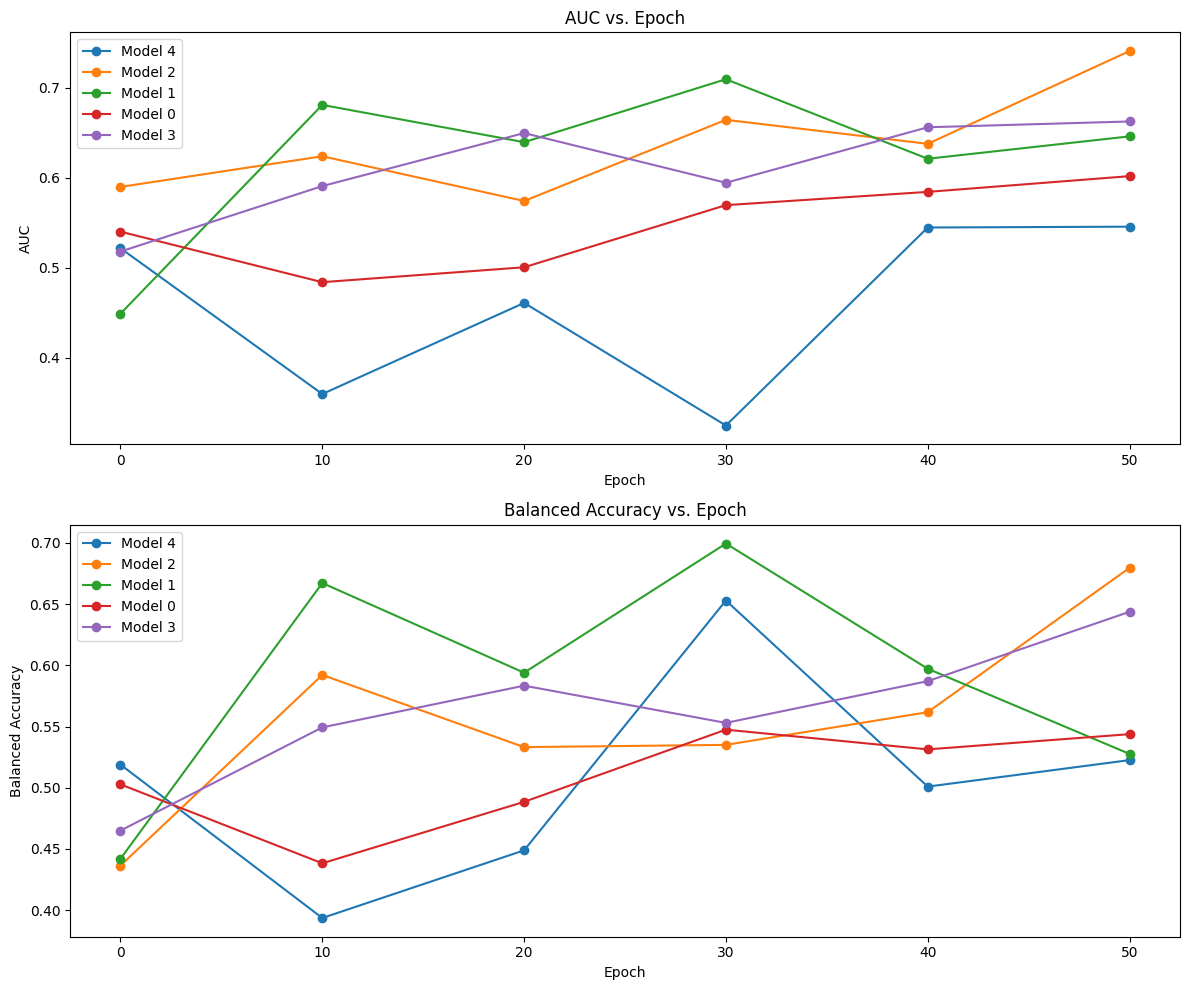

In [175]:
import re

# Initialize dictionaries to store data
auc_data = {'epoch': [], 'model': [], 'auc': []}
balanced_accuracy_data = {'epoch': [], 'model': [], 'balanced_accuracy': []}

# Parse eval_dic
for key, value in eval_dic.items():
    match = re.match(r'(auc|balanced_accuracy_score)_(Left_PCS|Right_PCS)_model(\d+)_epoch(\d+)', key)
    if match:
        metric, target, model, epoch = match.groups()
        model = int(model)
        epoch = int(epoch)
        if metric == 'auc':
            auc_data['epoch'].append(epoch)
            auc_data['model'].append(model)
            auc_data['auc'].append(value)
        elif metric == 'balanced_accuracy_score':
            balanced_accuracy_data['epoch'].append(epoch)
            balanced_accuracy_data['model'].append(model)
            balanced_accuracy_data['balanced_accuracy'].append(value)

# Convert to DataFrame
auc_df = pd.DataFrame(auc_data)
balanced_accuracy_df = pd.DataFrame(balanced_accuracy_data)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot AUC
for model in auc_df['model'].unique():
    model_data = auc_df[auc_df['model'] == model]
    ax[0].plot(model_data['epoch'], model_data['auc'], marker='o', label=f'Model {model}')
ax[0].set_title('AUC vs. Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('AUC')
ax[0].legend()

# Plot Balanced Accuracy
for model in balanced_accuracy_df['model'].unique():
    model_data = balanced_accuracy_df[balanced_accuracy_df['model'] == model]
    ax[1].plot(model_data['epoch'], model_data['balanced_accuracy'], marker='o', label=f'Model {model}')
ax[1].set_title('Balanced Accuracy vs. Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Balanced Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

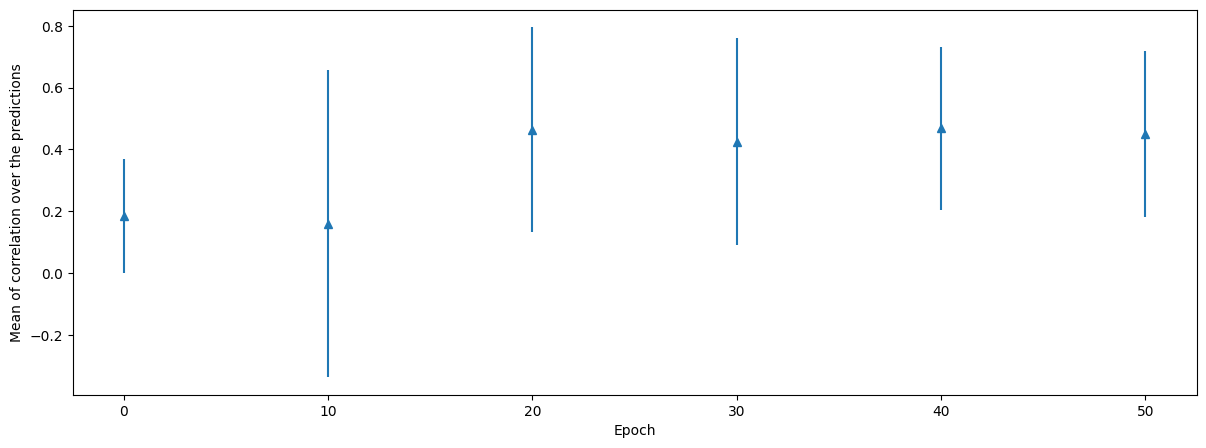

In [176]:
plt.figure(figsize = (14.5, 5))
plt.errorbar(np.sort(list(epochs)), list_corr_mean, list_corr_std, linestyle='None', marker='^')
plt.ylabel('Mean of correlation over the predictions')
plt.xlabel('Epoch')
plt.show()